# Collaborative Filtering

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## MovieLens dataset

In [2]:
df = pd.read_csv('data/ratings.zip').drop(columns='timestamp')
df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [3]:
df.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [4]:
df['userId'].nunique()

610

In [5]:
df['movieId'].nunique()

9724

In [6]:
sorted(df['rating'].unique())

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

We could potentially solve a seemingly simpler problem by converting movie ratings to a binary score which could be interpreted as whether or not the user liked the movie. We are not going to do this today, but feel free to experiment.

In [7]:
df['rating'] >= 3

0         True
1         True
2         True
3         True
4         True
          ... 
100831    True
100832    True
100833    True
100834    True
100835    True
Name: rating, Length: 100836, dtype: bool

We can pivot (or unmelt) the dataset to see more clearly the relationship between users and movies.

In [8]:
ratings = df.pivot(columns='movieId', index='userId', values='rating')
ratings

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most entries in the matrix are empty as users have watched only a small fraction of all available movies.

In [9]:
ratings.isna().values.reshape(-1, 1).mean()

0.9830003169443864

In [10]:
ratings.isna().mean().sort_values()

movieId
356       0.460656
318       0.480328
296       0.496721
593       0.542623
2571      0.544262
            ...   
58351     0.998361
4083      0.998361
58492     0.998361
58287     0.998361
193609    0.998361
Length: 9724, dtype: float64

In [11]:
ratings.T.isna().mean().sort_values()

userId
414    0.722542
599    0.745167
474    0.783217
448    0.808309
274    0.861580
         ...   
406    0.997943
207    0.997943
576    0.997943
278    0.997943
257    0.997943
Length: 610, dtype: float64

Let's create a reduced version of our dataset to speed up the training. For this, I will keep the movies and users that have a higher rating density.

In [12]:
users_idx = ratings.T.isna().mean().nsmallest(100).index
movies_idx = ratings.isna().mean().nsmallest(100).index
ratings = ratings.loc[users_idx, movies_idx]
ratings

movieId,356,318,296,593,2571,260,480,110,589,527,...,1073,4963,586,1527,33794,208,587,5989,1968,185
userId,,,,,,,,,,,,,,,,,,,,,
414,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,4.0,4.0,3.0,5.0,4.5,2.0,3.0,4.0,5.0,2.0
599,3.5,4.0,5.0,3.0,5.0,5.0,4.0,3.5,4.5,NaN,...,3.0,4.0,3.0,4.0,3.0,2.5,2.5,3.0,3.5,2.5
474,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,...,3.5,4.0,2.0,NaN,3.5,NaN,3.0,4.0,3.5,3.0
448,3.0,NaN,5.0,5.0,2.0,5.0,3.0,NaN,3.0,NaN,...,4.0,4.0,3.0,3.0,3.5,2.0,3.0,4.0,3.0,2.5
274,4.5,4.5,5.0,4.0,4.0,3.0,3.5,4.5,4.5,4.0,...,3.5,4.0,3.5,4.0,3.5,4.0,NaN,4.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,3.5,5.0,5.0,NaN,3.5,5.0,2.5,2.5,4.0,4.0,...,3.0,4.0,2.5,3.5,3.5,2.0,NaN,4.0,4.0,NaN
325,2.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,3.0,NaN,NaN,3.0,NaN,3.0,NaN
169,4.5,5.0,NaN,NaN,4.5,NaN,4.0,NaN,NaN,5.0,...,5.0,4.5,5.0,NaN,NaN,3.5,NaN,5.0,NaN,4.0


In [13]:
ratings.isna().values.reshape(-1, 1).mean()

0.3777

## User and movie features

In [14]:
n_features = 2 # 4 features seem to be optimal in this dataset, but the model is more expensive and harder to interpret.
user_feats = np.random.randn(ratings.shape[0] * n_features).reshape(ratings.shape[0], n_features)
movie_feats = np.random.randn(ratings.shape[1] * n_features).reshape(ratings.shape[1], n_features)

In [15]:
user_feats

array([[ 7.39195453e-01, -2.31506149e+00],
       [-1.78227547e-01, -1.68427936e+00],
       [-5.53766109e-01, -7.50895683e-01],
       [-1.94840805e+00,  2.04262941e+00],
       [-2.94298858e-01,  1.70228050e+00],
       [-1.37300770e-01,  1.53610955e+00],
       [ 6.56992433e-02, -4.80732098e-01],
       [-1.29596682e+00, -3.31778002e-01],
       [-9.03625629e-02,  4.76469375e-01],
       [ 1.50834464e+00, -2.03810978e+00],
       [-4.02840486e-01, -1.27196100e+00],
       [-1.87705197e-01, -1.05319176e+00],
       [-3.34932938e-01,  5.16824657e-01],
       [-1.02198507e+00, -1.65686004e+00],
       [-3.40131230e-02, -4.39117183e-01],
       [-4.84778998e-01,  2.70204637e-01],
       [ 4.28402882e-01, -5.31568331e-01],
       [-1.09559954e-01, -3.58724469e-01],
       [ 2.90410468e-01,  1.44128835e+00],
       [ 3.53018548e-01, -1.46113634e+00],
       [ 9.09808540e-01,  4.85608458e-01],
       [ 2.25066592e-01, -7.97032633e-03],
       [-7.95920067e-01,  6.10853189e-01],
       [-3.

In [16]:
movie_feats

array([[ 0.45696729, -0.06704767],
       [ 1.90012736, -1.42252559],
       [-0.18485541, -0.83107648],
       [ 0.67812508,  0.0635635 ],
       [ 0.56299211, -2.06372951],
       [ 0.12505823, -0.08258385],
       [ 1.07250568,  0.24781913],
       [-1.94133392,  3.20234083],
       [ 1.12505521,  0.43458448],
       [-1.42275033,  0.9335645 ],
       [-1.00841477,  0.36959076],
       [-0.15972032, -0.08774396],
       [ 0.55589661,  0.16630921],
       [-0.57962819, -0.24922157],
       [ 0.8621883 , -1.03974012],
       [ 0.75862323, -0.24620368],
       [ 0.48823029, -0.10216219],
       [ 1.19106472, -0.12231165],
       [-0.63916892,  1.21953989],
       [ 0.29443694, -1.72227546],
       [ 1.21904799, -0.45051039],
       [ 0.26904924, -2.31711443],
       [ 0.76181833,  0.8354881 ],
       [ 0.23437545, -0.8920731 ],
       [-0.80365215,  0.3217037 ],
       [ 0.1076938 , -0.82448366],
       [ 0.51708658, -0.16539443],
       [-0.48486351, -0.80960296],
       [-1.89033779,

In [17]:
user_feats.shape

(100, 2)

In [18]:
movie_feats.shape

(100, 2)

## Model
This matrix factorization algorithm will try to find optimal values for the user and movie features. These fitted features have values that produce predicted rankings with the smallest error possible.

In [19]:
def predict_rating(users, movies):
    return users.dot(movies.T)

def mse(pred, rating):
    return np.nanmean((pred - rating)**2) / 2

In [20]:
pred = predict_rating(user_feats, movie_feats)
pd.DataFrame(pred)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.493008,4.697800,1.787349,0.354114,5.193822,0.283629,0.219075,-8.848641,-0.174454,-3.212950,...,-3.652057,1.997754,3.004396,3.781851,0.017830,2.896260,-0.035130,0.030926,1.871955,-1.811206
1,0.031483,2.057275,1.432711,-0.227919,3.375556,0.116805,-0.608547,-5.047637,-0.932478,-1.318810,...,-1.512926,-0.238915,2.709200,2.555784,0.303896,3.184420,-0.191663,-0.072193,0.337387,-0.660257
2,-0.202707,0.015942,0.726418,-0.423252,1.237880,-0.007241,-0.780004,-1.329579,-0.949345,0.086861,...,0.083353,-1.227568,1.554552,1.009844,0.328201,2.133330,-0.195481,-0.094912,-0.528253,0.141154
3,-1.027312,-6.607916,-1.337407,-1.191428,-5.312373,-0.412353,-1.583476,10.323706,-1.304372,4.679025,...,5.293376,-4.826304,-1.703319,-3.690959,0.510929,-0.605201,-0.269703,-0.198708,-3.506349,2.788249
4,-0.248619,-2.980743,-1.360323,-0.091369,-3.678734,-0.177385,0.106220,6.022615,0.408682,2.007902,...,2.287149,-0.879877,-2.391345,-2.712724,-0.114378,-2.504636,0.083650,0.010221,-1.019838,1.102941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.522751,-2.904568,-0.336968,-0.671541,-1.910082,-0.184111,-0.967968,4.085238,-0.903802,2.090758,...,2.360099,-2.551372,-0.210804,-1.275132,0.338876,0.473601,-0.186596,-0.120438,-1.727452,1.276905
96,0.097727,2.385889,1.445805,-0.137195,3.549258,0.137920,-0.471906,-5.464674,-0.797259,-1.558749,...,-1.783267,0.092628,2.679389,2.665406,0.254155,3.057054,-0.163764,-0.055265,0.551401,-0.809841
97,0.352175,1.132230,-0.391699,0.569972,-0.141464,0.077725,0.944229,-0.648857,1.041206,-0.885986,...,-0.989513,1.890818,-1.039192,-0.226875,-0.370362,-1.726501,0.214590,0.115941,1.061558,-0.604706
98,-1.083353,-4.559031,0.397491,-1.599918,-1.428790,-0.299532,-2.523396,4.740953,-2.638743,3.407398,...,3.827562,-5.592065,1.655215,-0.719267,0.953902,3.474263,-0.544123,-0.311236,-3.398941,2.193672


In [21]:
resid = pred - ratings
resid

movieId,356,318,296,593,2571,260,480,110,589,527,...,1073,4963,586,1527,33794,208,587,5989,1968,185
userId,,,,,,,,,,,,,,,,,,,,,
414,-4.506992,-0.302200,-3.212651,-3.645886,0.193822,-4.716371,-3.780925,-13.848641,-5.174454,-7.212950,...,-7.652057,-2.002246,0.004396,-1.218149,-4.482170,0.896260,-3.035130,-3.969074,-3.128045,-3.811206
599,-3.468517,-1.942725,-3.567289,-3.227919,-1.624444,-4.883195,-4.608547,-8.547637,-5.432478,NaN,...,-4.512926,-4.238915,-0.290800,-1.444216,-2.696104,0.684420,-2.691663,-3.072193,-3.162613,-3.160257
474,-3.202707,-4.984058,-3.273582,-4.923252,-3.262120,-4.007241,-5.280004,-4.329579,-4.949345,-4.913139,...,-3.416647,-5.227568,-0.445448,NaN,-3.171799,NaN,-3.195481,-4.094912,-4.028253,-2.858846
448,-4.027312,NaN,-6.337407,-6.191428,-7.312373,-5.412353,-4.583476,NaN,-4.304372,NaN,...,1.293376,-8.826304,-4.703319,-6.690959,-2.989071,-2.605201,-3.269703,-4.198708,-6.506349,0.288249
274,-4.748619,-7.480743,-6.360323,-4.091369,-7.678734,-3.177385,-3.393780,1.522615,-4.091318,-1.992098,...,-1.212851,-4.879877,-5.891345,-6.712724,-3.614378,-6.504636,NaN,-3.989779,-5.019838,-1.897059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-4.022751,-7.904568,-5.336968,NaN,-5.410082,-5.184111,-3.467968,1.585238,-4.903802,-1.909242,...,-0.639901,-6.551372,-2.710804,-4.775132,-3.161124,-1.526399,NaN,-4.120438,-5.727452,NaN
325,-1.902273,-2.614111,-3.554195,-5.137195,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-2.907372,NaN,-0.334594,NaN,NaN,-3.163764,NaN,-2.448599,NaN
169,-4.147825,-3.867770,NaN,NaN,-4.641464,NaN,-3.055771,NaN,NaN,-5.885986,...,-5.989513,-2.609182,-6.039192,NaN,NaN,-5.226501,NaN,-4.884059,NaN,-4.604706


In [22]:
mse(pred, ratings)

8.845936901574367

In [23]:
def movie_grads(residuals, user_feats, movie_feats):
    return residuals.apply(lambda r: np.nanmean(r.values.reshape(-1, 1) * user_feats, axis=0)).T

def user_grads(residuals, user_feats, movie_feats):
    return residuals.apply(lambda r: np.nanmean(r.values.reshape(-1, 1) * movie_feats, axis=0), axis=1, result_type='expand')

def fit(ratings, user_feats, movie_feats, n_iter=100, rate=0.01):
    for i in range(n_iter):
        pred = predict_rating(user_feats, movie_feats)
        resid = pred - ratings
        print(mse(pred, ratings))
        
        u_grad = user_grads(resid, user_feats, movie_feats)
        m_grad = movie_grads(resid, user_feats, movie_feats)
        
        user_feats -= rate * u_grad
        movie_feats -= rate * m_grad
        
    return user_feats, movie_feats

In [24]:
user_feats, movie_feats = fit(ratings, user_feats, movie_feats, n_iter=100, rate=0.1)

8.845936901574367
8.346622708577472
8.090886941407796
7.9175102061091245
7.763450472756445
7.585943861272572
7.338445383608637
6.957981824002661
6.360362889167196
5.456696998117904
4.219160612960283
2.798537819061156
1.5564320130525047
0.7973678488728771
0.4723618517430885
0.3574481756424149
0.3160148987825539
0.29941363548749533
0.2918002107965818
0.2876596155555566
0.28496712229433147
0.2829504288930422
0.2813007594760194
0.2798852288803349
0.2786399039339322
0.2775292841784145
0.2765305621503632
0.2756272777646833
0.27480660776470356
0.27405810323180857
0.27337302977499495
0.2727439757203539
0.2721645911350365
0.2716293984878181
0.27113364741333607
0.2706731994516322
0.2702444346618734
0.26984417495214597
0.26946962055559603
0.26911829703418416
0.2687880108149139
0.26847681170147203
0.26818296112687023
0.26790490515778675
0.26764125145128836
0.2673907495139
0.2671522737314552
0.26692480873288027
0.26670743672728253
0.2664993265153669
0.2662997239263305
0.26610794347231886
0.26592336

## Results

In [25]:
predict_rating(user_feats, movie_feats)

movieId,356,318,296,593,2571,260,480,110,589,527,...,1073,4963,586,1527,33794,208,587,5989,1968,185
userId,,,,,,,,,,,,,,,,,,,,,
414,4.638184,4.999351,5.040530,4.719008,4.744210,4.796166,4.089269,4.441804,4.494698,4.812308,...,4.367098,4.159405,3.516266,4.176728,4.354834,3.347899,3.525210,4.389155,4.340059,2.972640
599,3.894556,4.178494,4.187831,3.958044,3.998037,4.003962,3.448734,3.735727,3.784919,4.004627,...,3.649705,3.552455,2.900313,3.540345,3.652243,2.785510,2.968258,3.658022,3.644220,2.468285
474,4.194064,4.532641,4.585543,4.269866,4.280966,4.351347,3.688346,4.012722,4.057586,4.373943,...,3.959627,3.723942,3.211970,3.756150,3.940571,3.043234,3.182549,3.985905,3.924491,2.705229
448,4.104130,4.438492,4.494237,4.178997,4.186891,4.261704,3.606878,3.925721,3.968870,4.285846,...,3.877435,3.634646,3.151322,3.670364,3.856765,2.982016,3.113007,3.904758,3.840338,2.651595
274,4.138506,4.365264,4.277266,4.188984,4.304539,4.164576,3.723284,3.993259,4.064069,4.115281,...,3.811482,4.007417,2.879481,3.891142,3.863975,2.860564,3.186135,3.780738,3.872453,2.515204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,3.934648,4.255386,4.309068,4.006465,4.013855,4.085935,3.457788,3.763550,3.804871,4.109203,...,3.717479,3.483985,3.021681,3.518480,3.697540,2.859115,2.984376,3.743769,3.681750,2.542360
325,3.812078,4.260581,4.492531,3.912870,3.785779,4.124382,3.242523,3.603065,3.609036,4.238810,...,3.724489,2.948313,3.299676,3.171756,3.613667,2.952757,2.832695,3.822700,3.567122,2.661056
169,4.888742,5.210421,5.176763,4.960564,5.044623,4.984280,4.356234,4.700272,4.770612,4.961943,...,4.550413,4.567029,3.546848,4.503907,4.576675,3.450506,3.740788,4.542509,4.574484,3.048471


In [26]:
ratings

movieId,356,318,296,593,2571,260,480,110,589,527,...,1073,4963,586,1527,33794,208,587,5989,1968,185
userId,,,,,,,,,,,,,,,,,,,,,
414,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,4.0,4.0,3.0,5.0,4.5,2.0,3.0,4.0,5.0,2.0
599,3.5,4.0,5.0,3.0,5.0,5.0,4.0,3.5,4.5,NaN,...,3.0,4.0,3.0,4.0,3.0,2.5,2.5,3.0,3.5,2.5
474,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,...,3.5,4.0,2.0,NaN,3.5,NaN,3.0,4.0,3.5,3.0
448,3.0,NaN,5.0,5.0,2.0,5.0,3.0,NaN,3.0,NaN,...,4.0,4.0,3.0,3.0,3.5,2.0,3.0,4.0,3.0,2.5
274,4.5,4.5,5.0,4.0,4.0,3.0,3.5,4.5,4.5,4.0,...,3.5,4.0,3.5,4.0,3.5,4.0,NaN,4.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,3.5,5.0,5.0,NaN,3.5,5.0,2.5,2.5,4.0,4.0,...,3.0,4.0,2.5,3.5,3.5,2.0,NaN,4.0,4.0,NaN
325,2.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,3.0,NaN,NaN,3.0,NaN,3.0,NaN
169,4.5,5.0,NaN,NaN,4.5,NaN,4.0,NaN,NaN,5.0,...,5.0,4.5,5.0,NaN,NaN,3.5,NaN,5.0,NaN,4.0


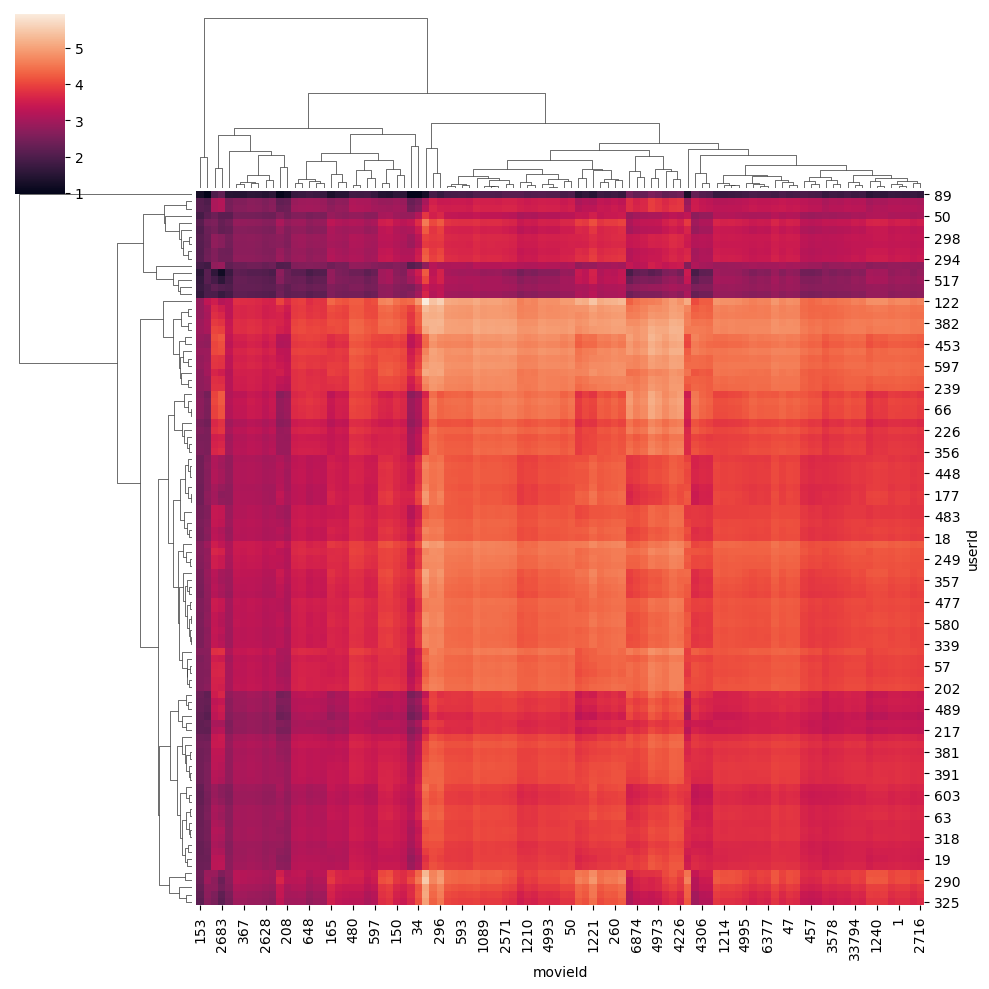

In [27]:
sns.clustermap(predict_rating(user_feats, movie_feats))
plt.show()

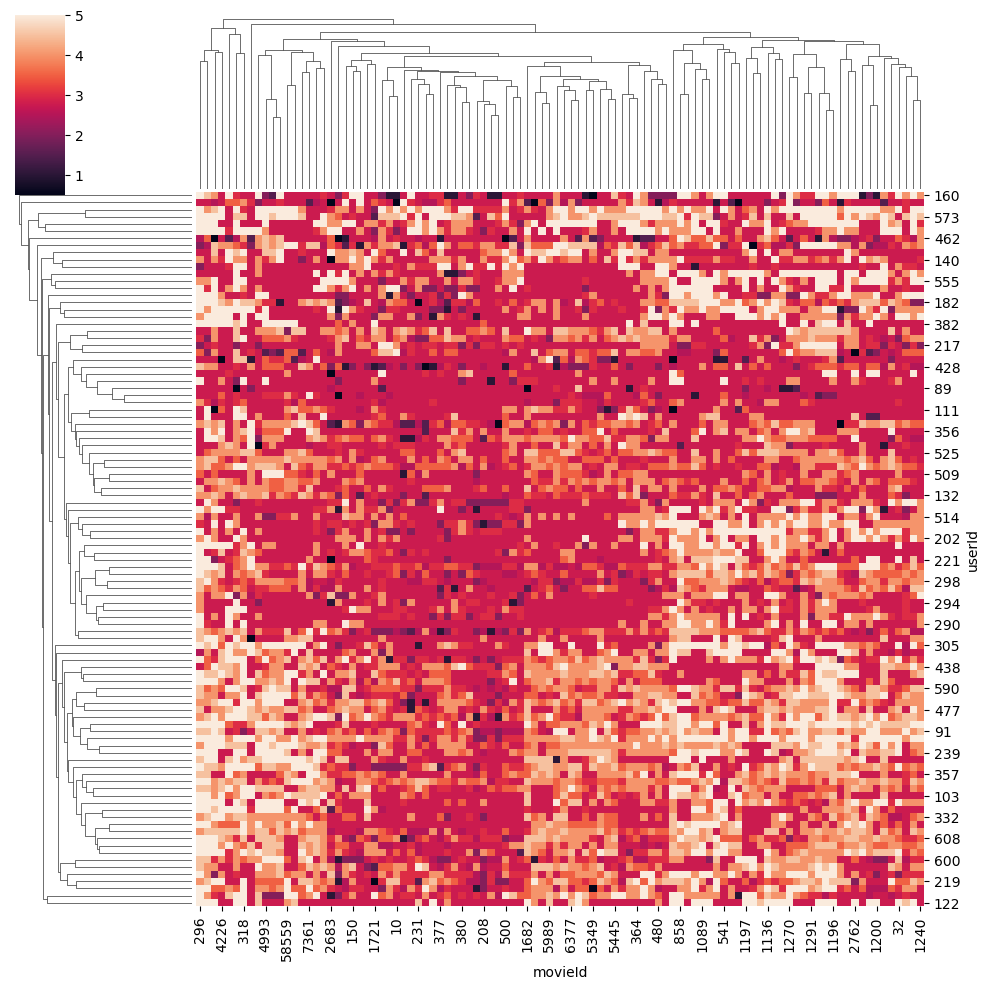

In [28]:
sns.clustermap(ratings.fillna(2.75))
plt.show()

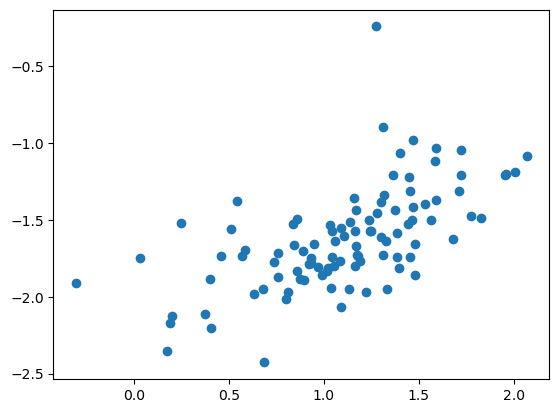

In [29]:
plt.scatter(user_feats[0], user_feats[1])
plt.show()

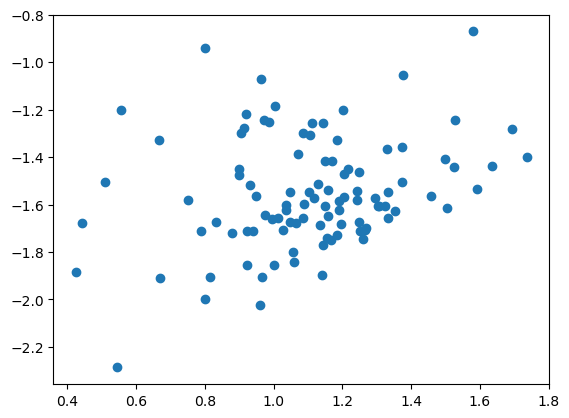

In [30]:
plt.scatter(movie_feats[0], movie_feats[1])
plt.show()